# In this assignment we learn how to derive a neural network emulator based on the cosmopower emulator (Mancini et al. 2021). Based on this emulator we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [1]:
# Import all of the necessary modules and functions
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from cosmopower import cosmopower_NN
import tensorflow as tf
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
# This cell is for formatting plots, and can be commented out if it causes problems
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

## Preparation: load in the all the 10000 model vectors and corresponding parameters that we use to bulit the emulator.

In [3]:
models = np.load('data_4_assignment2/models.npy')
parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys(),models.shape

(KeysView(NpzFile 'data_4_assignment2/parameters.npz' with keys: omega_m, omega_b, As, w),
 (10000, 900))

#### Divide the models and parameters in a training and test set. 

The variable `frac` at the top of the following cell can be modified to set what fraction (0 – 1) of the 10,000 model vectors are to be used for the training set. The rest are used for the testing set.

In [4]:
frac = 0.7 # the fraction of data arrays to be used for training

div = int(len(models)*frac) # boundary index between training and test data sets
train_sample = np.arange(0,div) # select the elements to be used for training
test_sample = np.arange(div,len(models)) # select the elements to be used for testing

# get the parameters for the training set
train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])

# get the parameters for the testing set 
test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = np.load('data_4_assignment2/models.npy')[train_sample] # load in the training features
test_features = np.load('data_4_assignment2/models.npy')[test_sample] # load in the testing features

print('Training set shape:\t',np.shape(train_features)) # print the shape of the training set
print('Testing set shape:\t',np.shape(test_features)) # print the shape of the testing set

Training set shape:	 (7000, 900)
Testing set shape:	 (3000, 900)


We see from the print statement above that, since we set `frac=0.7`, 7000 of the 10,000 model vectors are used for training, while the remaining 3000 are used for testing. We also see that the model vectors each contain 900 points.

#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

The below cell contains the hyper-parameters that I found to produce good results, while still being able to run on my laptop in a reasonable amount of time. The most important parameters to change were the number of neurons `n_hidden`, the series of `learning_rates`, and the `batch_size`.

Increasing the number of neurons generally improved the accuracy and decreased the loss of the emulator, though it also took longer to run, as would be expected. As the number of neurons continued to increased, the improvement in loss became progressively less significant. A value of ~700 total neurons produced results with loss on the order of $10^{-4}$, and the current value of ~2000 total neurons produces loss around $5\cdot10^{-5}$.

Changing the learning rates significantly affected the accuracy of the emulator. Starting with a learning rate of $1$ typically produced very large loss as the step sizes were apparently too big. Starting with a learning rate of $0.1$ produced inconsistent results, and so was avoided. The best results were found starting with a learning rate of $0.01$ and decreasing it by an order of magnitude with each iteration. The improvements in the loss are typically very minimal below a learning rate of $10^{-5}$. The learning rate itself did not significantly affect the speed of the training, though adding more learning rates of course increased the number of iterations through which the emulator had to run.

Increasing the batch size slightly reduced the accuracy of the emulator, but helped the training to run much faster. Using the 7000 training sets that were selected in the previous cell, a batch size of 350 was able to get good results while still running in a reasonable amount of time on my laptop.

The only other hyper-parameter that we changed to improve the accuracy of the emulator was the `max_epochs`. A greater value of this parameter allows the emulator to continue running if the loss is being improved until the maximum number of epochs is reached. I set this to a high value of 1000 to give the emulator time to reach optimal values. Though this maximum number is still occationally hit, I'm confident that the emulator is being well trained with this parameter.

In [5]:
# Here we normalize the training set to improve the accuracy of the emulator
train_min = np.min(train_features,axis=0)
features_modified = train_features - train_min
train_max = np.max(features_modified,axis=0)
features_modified = features_modified / train_max

# Initialize the neural network
cp_nn = cosmopower_NN(parameters=list(parameters.keys()),
                    modes=np.linspace(-1,1,train_features.shape[1]),
                    n_hidden = [512,512,512,512], # This you should modify. In this exmaple we use three layers with 4, 5 and 6 nodes. Is this enough?
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

device = 'cpu'

# Train the emulator on the data set
with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                filename_saved_model='data_4_assignment2/emulator_test', # the name of the emulator and where to save it
                # cooling schedule
                validation_split=0.1, # the precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different learning rates
                batch_sizes=[350, 350, 350, 350, 350], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1, 1, 1, 1, 1], # batches for gradient accumulations
                patience_values = [100, 100, 100, 100, 100], # number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000, 1000, 1000, 1000, 1000] # maxmimal number of epoch before decreasing the learning rate
                )



Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[350, 350, 350, 350, 350] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 350


 50%|█████     | 501/1000 [06:45<06:43,  1.24it/s, loss=0.00299]


Validation loss = 0.0017035152
Model saved.
Reached max number of epochs. Validation loss = 0.0017035152
Model saved.
learning rate = 0.001, batch size = 350


 27%|██▋       | 266/1000 [03:32<09:46,  1.25it/s, loss=0.000275]


Validation loss = 0.00020591724
Model saved.
Reached max number of epochs. Validation loss = 0.00020591724
Model saved.
learning rate = 0.0001, batch size = 350


 83%|████████▎ | 826/1000 [10:56<02:18,  1.26it/s, loss=8.86e-5] 


Validation loss = 8.44163e-05
Model saved.
Reached max number of epochs. Validation loss = 8.44163e-05
Model saved.
learning rate = 1e-05, batch size = 350


 10%|█         | 102/1000 [01:22<12:09,  1.23it/s, loss=7.16e-5]


Validation loss = 6.989367e-05
Model saved.
Reached max number of epochs. Validation loss = 6.989367e-05
Model saved.
learning rate = 1e-06, batch size = 350


 10%|█         | 100/1000 [01:21<12:11,  1.23it/s, loss=6.7e-5] 

Validation loss = 6.596979e-05
Model saved.
Reached max number of epochs. Validation loss = 6.596979e-05
Model saved.


#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

In the cell below, I compute and plot the relative difference between the test samples and the emulated models. The black line represents the median difference between the test samples and the model, while the coloured contours represent where 68%, 95% and 99% of the predictions lie.

Note that emulator trained in the above cell is used for this analysis by default, but the top line of the following cell can be un-commented and changed to load in a previously trained emulator from a data file.

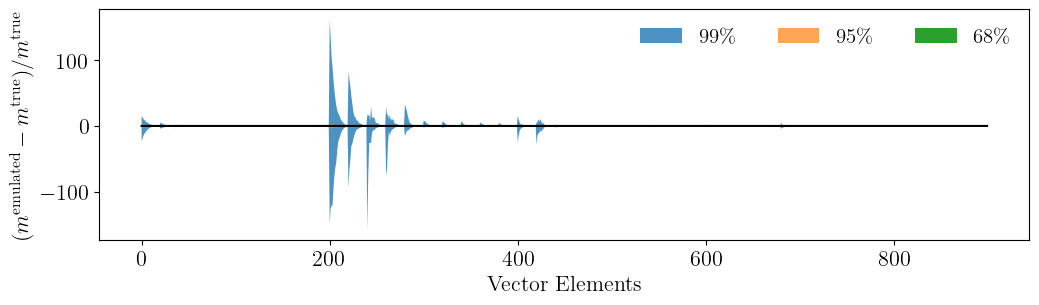

In [6]:
#cp_nn = cosmopower_NN(restore=True,restore_filename='data_4_assignment2/emulator_test_old') # restore a previous emulator model from a file

emulated_features = cp_nn.predictions_np(test_params) # use the emulator to predict the model based on the testing parameters

# rescale the previously normalized emulator features back to the original data vectors
emulated_features *= train_max
emulated_features += train_min

diff=((emulated_features)/(test_features)-1) # measure the relative difference between test sample and the emualted models

# Calculate the mean relative difference between the test sample and the emualted models,
# as well as the 68%, 95% and 99% contours
mean_diff = np.median(diff,axis=0)
percentiles3 = np.percentile(diff,[16,84],axis=0)
percentiles2 = np.percentile(diff,[2.5,97.5],axis=0)
percentiles1 = np.percentile(diff,[0.5,99.5],axis=0)
bins=range(diff.shape[1])

# Plot the mean relative difference between test sample and the emualted models,
# along with the 68%, 95% and 99% contours
plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins,percentiles1[0],percentiles1[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins,percentiles2[0],percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins,percentiles3[0],percentiles3[1], label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.legend(frameon=False, fontsize=15, ncol=3, loc='upper right')
plt.ylabel(r'$( m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$')
plt.xlabel(r'Vector Elements')
plt.show()

We see in the above plot that the mean relative difference between the test samples and the model is very near $0$, and $95\%$ of the differences lay very near zero as well. However, the $99\%$ contour is very large at some points along the vector. I believe that this is because the model sometimes approaches very small values, and so the relative difference can get very large if the emulator is slightly off at those points.

To better examine the scatter in the mean and the inner contours, I plot the same data as above in the cell below, but with a limit on the y-axis.

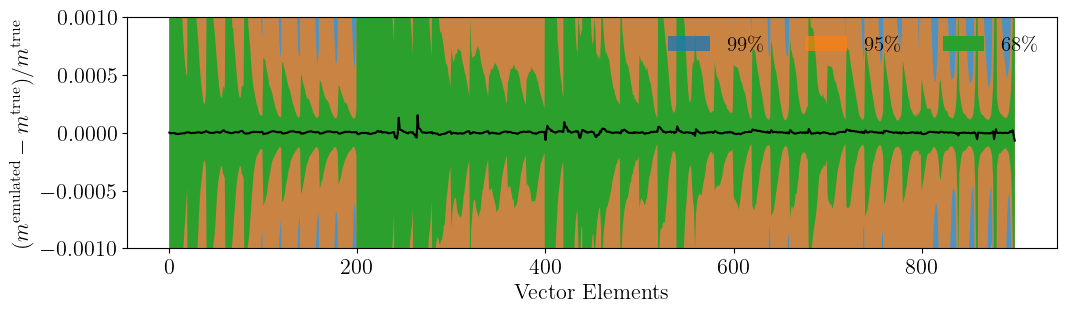

In [7]:
# Plot the mean relative difference between test sample and the emualted models,
# along with the 68%, 95% and 99% contours with a y-limit to better see the scatter
plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins,percentiles1[0],percentiles1[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins,percentiles2[0],percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins,percentiles3[0],percentiles3[1], label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.legend(frameon=False, fontsize=15, ncol=3, loc='upper right')
plt.ylabel(r'$( m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$')
plt.xlabel(r'Vector Elements')
plt.ylim(-0.001,0.001)
plt.show()

We see from the above cell that the scatter in the mean relative difference is of the order $10^{-4}$, which is very small. Similarly, the $68\%$ contours for the prdictions are of the order $10^{-3}$. This demonstrates that the emulator generally does a very good job at predicting the model, though it misses some points along the vector in a minority of cases.

In order to get another look at how well the emulator performs, I chose to plot the difference between the test samples and the emulated samples in terms of the scatter in the test samples. I do so in the cells below, with the same mean value and percentage contours.

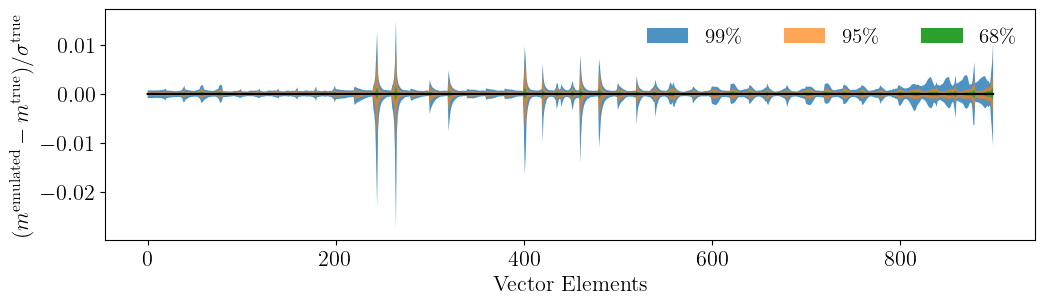

In [8]:
# Measure the relative difference between test sample and the emualted models
# over the standard deviation in the test sets
diff=(emulated_features - test_features) / np.std(test_features,axis=0)

# Calculate the difference between test sample and the emualted models
# over the standard deviation in the test sets, along with the 68%, 95% and 99% contours
mean_diff = np.median(diff,axis=0)
percentiles3 = np.percentile(diff,[16,84],axis=0)
percentiles2 = np.percentile(diff,[2.5,97.5],axis=0)
percentiles1 = np.percentile(diff,[0.5,99.5],axis=0)
bins=range(diff.shape[1])

# Plot the difference between test sample and the emualted models
# over the standard deviation in the test sets, along with the 68%, 95% and 99% contours
plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins,percentiles1[0],percentiles1[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins,percentiles2[0],percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins,percentiles3[0],percentiles3[1], label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.legend(frameon=False, fontsize=15, ncol=3, loc='upper right')
plt.ylabel(r'$( m^{\mathrm{emulated}} - m^{\mathrm{true}})/  \sigma^{\mathrm{true}}$')
plt.xlabel(r'Vector Elements')
plt.show()

We see from the above plot that $95\%$ of the emulator predictions fall within $0.01\sigma$ of the scatter in the test samples, which reassures us that the emulator is performing well. To better examine the scatter in the mean and the inner contours, I plot the same data as above in the cell below, but with a limit on the y-axis.

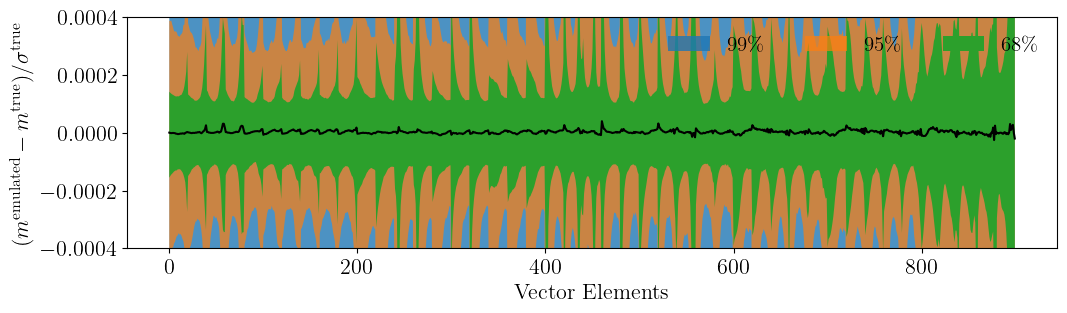

In [9]:
# Measure the relative difference between test sample and the emualted models
# over the standard deviation in the test sets
diff=(emulated_features - test_features) / np.std(test_features,axis=0)

# Calculate the difference between test sample and the emualted models
# over the standard deviation in the test sets, along with the 68%, 95% and 99% contours
mean_diff = np.median(diff,axis=0)
percentiles3 = np.percentile(diff,[16,84],axis=0)
percentiles2 = np.percentile(diff,[2.5,97.5],axis=0)
percentiles1 = np.percentile(diff,[0.5,99.5],axis=0)
bins=range(diff.shape[1])

# Plot the difference between test sample and the emualted models
# over the standard deviation in the test sets, along with the 68%, 95% and 99% contours
plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins,percentiles1[0],percentiles1[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins,percentiles2[0],percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins,percentiles3[0],percentiles3[1], label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.legend(frameon=False, fontsize=15, ncol=3, loc='upper right')
plt.ylabel(r'$( m^{\mathrm{emulated}} - m^{\mathrm{true}})/  \sigma^{\mathrm{true}}$')
plt.xlabel(r'Vector Elements')
plt.ylim(-0.0004,0.0004)
plt.show()

We see from the above plot that $65\%$ of the emulator predictions fall within $(5\cdot10^{-4})\sigma$ of the scatter in the test samples.

##### Next we want perform a Fisher Analysis using the emualtor. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

Here, I first compute the range of $\Omega_m$ and $\omega$ parameters and print the result to get an idea of how much the parameters vary over our test set. Then, I choose the step size over which to numerically compute the partial derivatives of the model to be one thousanth of the range of each parameter. I previously tried decreasing the size of this shift by an order of magnitude, but it yielded the same results. So, we can be confident that this step size for each parameter is reasonable. Once this step size has been established, I compute the partial derivatives of our emulator model with respect to $\Omega_m$ and $\omega$ using the five point stencil beam formula given above.

In [10]:
Om_range = np.max(test_params['omega_m'])-np.min(test_params['omega_m']) # compute the range of Omega_m parameters
w_range = np.max(test_params['w'])-np.min(test_params['w']) # compute the range of w parameters

# Print the range of Omega_m and w parameters
print('Omega_m range:\t{:.4f}'.format(Om_range))
print('w range:\t{:.4f}'.format(w_range))

Om_shift = Om_range/1e3 # choose a reasonable stepsize in Omega_m, based on the range of values
w_shift = w_range/1e3 # choose a reasonable stepsize in w, based on the range of values

# This example compute the model for two different Omega_m values.
#paramters = {'omega_m':[0.3,0.31,],'w':[-1,-1],'As':[np.mean(test_params['As'])]*2,'omega_b':[np.mean(test_params['omega_b'])]*2}
    
#features_4_div = cp_nn.predictions_np(paramters)
# if you modified the training features you need to convert back the output back the original data vectors

Om = np.mean(test_params['omega_m']) # compute the mean Omega_m value
w = np.mean(test_params['w']) # compute the mean w value

# Set the parameters with which to compute the model for two different Omega_m values
parameters_Om = {'omega_m':[Om+2.*Om_shift,Om+Om_shift,Om-Om_shift,Om-2.*Om_shift],'w':[w]*4,'As':[np.mean(test_params['As'])]*4,
                 'omega_b':[np.mean(test_params['omega_b'])]*4}
# Set the parameters with which to compute the model for two different w values
parameters_w = {'omega_m':[Om]*4,'w':[w+2.*w_shift,w+w_shift,w-w_shift,w-2.*w_shift],'As':[np.mean(test_params['As'])]*4,
                'omega_b':[np.mean(test_params['omega_b'])]*4}

# Compute the model for different parameter values,
# and rescale the previously normalized emulator features back to the original data vectors
features_Om = cp_nn.predictions_np(parameters_Om) * train_max + train_min
features_w = cp_nn.predictions_np(parameters_w) * train_max + train_min

# Compute the derivatives of the model features with respect to Omega_m and w
derivative_Om = ( -features_Om[0] + 8.*features_Om[1] - 8.*features_Om[2] + features_Om[3] ) / (12.*Om_shift) # compute derivative
derivative_w = ( -features_w[0] + 8.*features_w[1] - 8.*features_w[2] + features_w[3] ) / (12.*w_shift) # compute derivative

Omega_m range:	0.4997
w range:	1.6985


#### So lets compute the Fisher matrix the corresponding covariance matrix of the paramters:

In this cell, I compute the Fisher matrix and the covariance matrix using the formulae provided above and the derivatives computed in the previous cell. Then, I compute the constraints for the parameters $\Omega_m$ and $\omega$ from the covariance matrix, and print all of the results.

In [11]:
cov=np.load('data_4_assignment1/covariance.npy') # load the covariance matrix from the data file
inv_cov = inv(cov) # compute the inverse of the covariance matrix

# Compute the elements of the Fisher matrix using the previsously computed derivatives
FoM_11 = derivative_Om.T @ inv_cov @ derivative_Om
FoM_22 = derivative_w.T @ inv_cov @ derivative_w
FoM_12 = derivative_Om.T @ inv_cov @ derivative_w
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]]) # construct the Fisher matrix
# Print the Fisher matrix
print('Fisher matrix:')
print(FoM_best)
print()

Cov_parameter = inv(FoM_best) # compute the covariance matrix as the inverse of the Fisher matrix
max_constraints = np.sqrt(np.diag(Cov_parameter)) # compute the constraints on each parameter from the covariance matrix
# Print the covariance matrix and the constraints on Omega_m and w
print('Covariance matrix:')
print(Cov_parameter)
print()
print('Maximum constraints of (Omega_m, w):')
print(max_constraints)

Fisher matrix:
[[5460408.11593495 -201185.54169486]
 [-201185.54169486   10581.04063239]]

Covariance matrix:
[[6.11579203e-07 1.16284303e-05]
 [1.16284303e-05 3.15609037e-04]]

Maximum constraints of (Omega_m, w):
[0.00078204 0.01776539]


#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the a covariance on the PCA elements. Now it should get clear why you had to genereate the 100k multivariate Gaussian random variables. 

The variable `N_pca` at the top of the following cell can be modified to change the number of PCA elements. The cell then performs a PCA fitting of our model with the given number of elements, and applies the associated transformation to the given covariance matrix. Finally, we compute the correlation matrix from the covariance matrix and plot the result. For this cell, I chose 225 components, as it is one quarter of the total 900 elements to the model vector. Other choices for number of PCA elements are explored later.

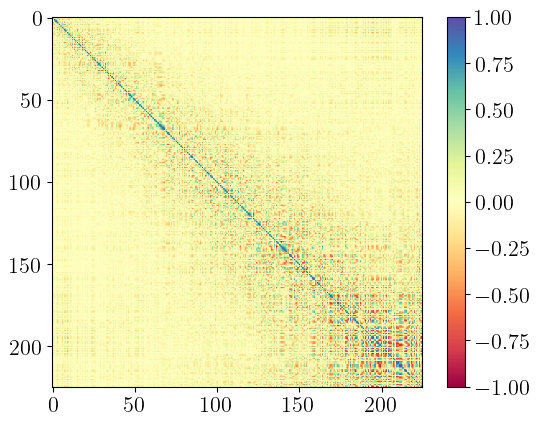

In [12]:
N_pca = 225 # decide how many PCA eigenvalues to use
models = np.load('data_4_assignment2/models.npy') # load on the model data from file
mean = np.mean(models,axis=0) # for numerical stability, subtract the mean of each element
pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
models_pca = pca.fit_transform(models-mean) # perform the PCA fitting

rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
cov_pca = rotation_matrix.T @ cov @ rotation_matrix # rotate covariance matrix

# Plot the correlation matrix from the PCA covariance
plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1,cmap='Spectral')
plt.colorbar()
plt.show()

We see in the above matrix that there is some noisy correlation near the diagonal of the matrix, but very little noise far from the diagonal. To get a better idea of how the number of PCA elements affects the correlation matrix, we do the same analysis for different numbers of elements in the following two cells.

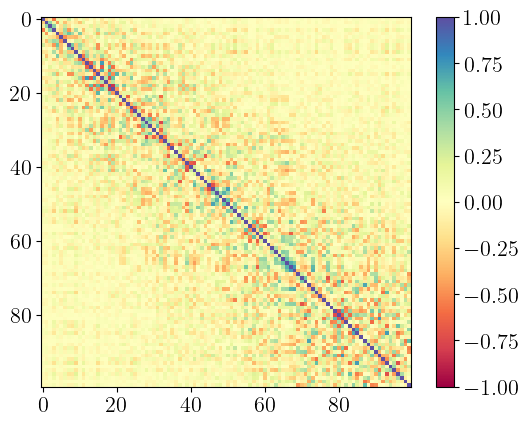

In [13]:
# Do the same analysis with fewer PCA eigenvalues
N_pca = 100 # decide how many PCA eigenvalues to use
pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
models_pca = pca.fit_transform(models-mean) # perform the PCA fitting
rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
cov_pca = rotation_matrix.T @ cov @ rotation_matrix # rotate covariance matrix

# Plot the correlation matrix from the PCA covariance
plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1,cmap='Spectral')
plt.colorbar()
plt.show()

In the above plot, we see that decreasing the number of PCA elements leads to more noisy correlation on the off-diagonal. This is expected, as effectively trying to reduce the dimension of the model should lead to noisier correlated points.

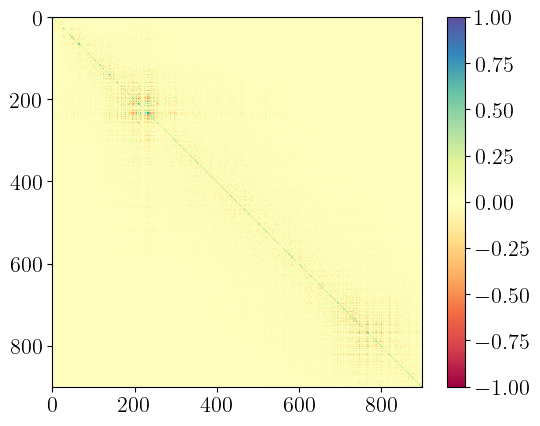

In [14]:
# Do the same analysis with more PCA eigenvalues
N_pca = 900 # decide how many PCA eigenvalues to use
pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
models_pca = pca.fit_transform(models-mean) # perform the PCA fitting
rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
cov_pca = rotation_matrix.T @ cov @ rotation_matrix # rotate covariance matrix

# Plot the correlation matrix from the PCA covariance
plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1,cmap='Spectral')
plt.colorbar()
plt.show()

In the above plot, we see that increasing the number of PCA elements to equal the dimension of the model vector leads to much less noisy correlation overall. This is expected, as effectively increasing the dimension of the model should lead to less noisy correlated points.

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

The following cell loops from 1 to 900 PCA elements and computes the constraints for $\Omega_m$ and $\omega$ for each iteration. Since the loop takes a long time to run, the resulting constraints are saved in a text file at the end, which can then be loaded later for easy analysis.

In [15]:
paramter_constraints = [] # initialize an array for parameter constraints
# Loop through all numbers of PCA elements
for N_pca in tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full') # initialize a PCA class
    models_pca = pca.fit_transform(models-mean) # perform the PCA fitting
    rotation_matrix = pca.components_.T # create a rotation matrix from the PCA fit
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix # rotate covariance matrix
    inv_cov_pca = inv(cov_pca) # compute the inverse of the covariance matrix from the PCA fit

    # Transform the features of the emulator prediction for different parameter values
    features_Om_pca = pca.transform(features_Om)
    features_w_pca = pca.transform(features_w)

    # Compute the derivatives of the transformed features with respect to Omega_m and w
    derivative_Om_pca = ( -features_Om_pca[0] + 8.*features_Om_pca[1] - 8.*features_Om_pca[2] + features_Om_pca[3] ) / (12.*Om_shift)
    derivative_w_pca = ( -features_w_pca[0] + 8.*features_w_pca[1] - 8.*features_w_pca[2] + features_w_pca[3] ) / (12.*w_shift)

    # Compute the elements of the Fisher matrix using the derivatives
    FoM_11 = derivative_Om_pca.T @ inv_cov_pca @ derivative_Om_pca
    FoM_22 = derivative_w_pca.T @ inv_cov_pca @ derivative_w_pca
    FoM_12 = derivative_Om_pca.T @ inv_cov_pca @ derivative_w_pca
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]]) # construct the Fisher matrix

    Cov_parameter_pca = inv(FoM_best_pca) # compute the covariace matrix from the PCA Fisher matrix
    paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca))) # conpute the parameter constraints from the covariance matrix

paramter_constraints = np.array(paramter_constraints) # append the parameter constraints from the PCA analysis to the dedicated list

np.savetxt('data_4_assignment2/parameter_constraints.dat',paramter_constraints) # save the parameter constraints in a text file

  0%|          | 0/899 [00:00<?, ?it/s]C:\Users\yusuf\AppData\Local\Temp\ipykernel_25552\1949156606.py:26: RuntimeWarning: invalid value encountered in sqrt
  paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca))) # conpute the parameter constraints from the covariance matrix
100%|██████████| 899/899 [29:52<00:00,  1.99s/it]


### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power?

The following cell plots the constraints of $\Omega_m$ as a function of the number of PCA elements, in terms of the Fisher analysis constraint. The solid, black, horizontal line at $1$ represents the maximum constraint computed from the Fisher analysis. The dashed, light and dark grey horizontal lines represent $10\%$ and $1\%$ of the maximum constraining power of the Fisher analysis, respectively. This cell also prints out the number of PCA elements required to reach $10\%$ and $1\%$ of the maximum constraining power, as can be seen below.

The first point in the analysis, representing 1 PCA element, was cut out of the plot. This was done because this point has much worse constraining power than any of the other numbers of elements (~$10^8$), and it made the rest of the structure impossible to properly observe.

Note that constraints computed in the above cell are used for this analysis by default, but the top line of the following cell can be un-commented and changed to load in previously computed constraints from a text file.

PCA elements for 10% constraining power for Omega_m:	 116
PCA elements for 1% constraining power for Omega_m:	 491


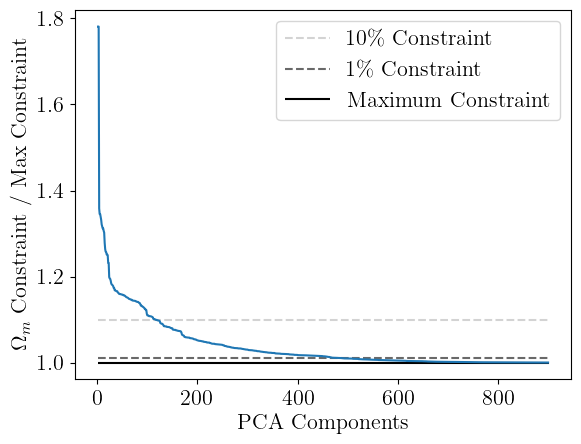

In [16]:
#paramter_constraints = np.loadtxt('data_4_assignment2/parameter_constraints_old.dat') # load the parameter constraints from a file

# Print the number of PCA elements needed to get 10% and 1% of the maximum constraining power on Omega_m
print('PCA elements for 10% constraining power for Omega_m:\t',np.where(paramter_constraints[:,0]/max_constraints[0] < 1.1)[0][0])
print('PCA elements for 1% constraining power for Omega_m:\t',np.where(paramter_constraints[:,0]/max_constraints[0] < 1.01)[0][0])

# Plot the constraints on Omega_m as a function of number of PCA components
plt.figure()
plt.hlines(1.1,1,900,'lightgrey','--',label='10\% Constraint') # 10% constraint line
plt.hlines(1.01,1,900,'dimgrey','--',label='1\% Constraint') # 1% constraint line
plt.hlines(1.,1,900,'black','-',label='Maximum Constraint') # maximum constraint line
plt.plot(np.arange(2,900),paramter_constraints[1:,0]/max_constraints[0],'tab:blue') # constraint vs PCA
plt.xlabel('PCA Components')
plt.ylabel('$\Omega_m$ Constraint / Max Constraint')
plt.legend()
plt.show()

The following cell plots the constraints of $\omega$ as a function of the number of PCA elements, in terms of the Fisher analysis constraint. The plot is analogous to that in the previous cell. This cell also prints out the number of PCA elements required to reach $10\%$ and $1\%$ of the maximum constraining power.

The first point in the analysis, representing 1 PCA element, was cut out of the plot. This was done because this point has much worse constraining power than any of the other numbers of elements (~$10^8$), and it made the rest of the structure impossible to properly observe.

PCA elements for 10% constraining power for w:	 167
PCA elements for 1% constraining power for w:	 591


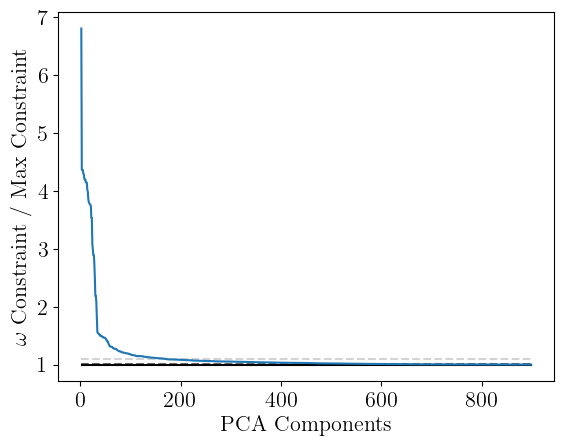

In [17]:
# Print the number of PCA elements needed to get 10% and 1% of the maximum constraining power on w
print('PCA elements for 10% constraining power for w:\t',np.where(paramter_constraints[:,1]/max_constraints[1] < 1.1)[0][0])
print('PCA elements for 1% constraining power for w:\t',np.where(paramter_constraints[:,1]/max_constraints[1] < 1.01)[0][0])

# Plot the constraints on Omega_m as a function of number of PCA components
plt.figure()
plt.hlines(1.1,1,900,'lightgrey','--',label='10\% Constraint') # 10% constraint line
plt.hlines(1.01,1,900,'dimgrey','--',label='1\% Constraint') # 1% constraint line
plt.hlines(1.,1,900,'black','-',label='Maximum Constraint') # maximum constraint line
plt.plot(np.arange(2,900),paramter_constraints[1:,1]/max_constraints[1]) # constraint vs PCA
plt.xlabel('PCA Components')
plt.ylabel('$\omega$ Constraint / Max Constraint')
plt.show()

We see from the outputs of the above two cells that increasing the number of PCA elements allows the constraining power for $\Omega_m$ and $\omega$ to approach the maximum constraining power given by the Fisher analysis. For both parameters, using too few PCA elements results in much worse constraints, but a reasonable constraint can be approached fairly rapidly by increasing the number of elements. However, as we get close to the maximum constraint, adding more PCA elements has a progressively less significant effect. The precise values for the number of PCA elements required to each $10\%$ and $1\%$ of the maximum constraining power for each parameter can be seen in the printed outputs of the above two cells.